In [1]:
import os
import glob
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd

In [4]:
pip install matplotlib

     ---------------------------------------- 7.2/7.2 MB 10.5 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 10.6 MB/s eta 0:00:00
     ------------------------------------- 965.4/965.4 kB 10.2 MB/s eta 0:00:00
     ---------------------------------------- 54.9/54.9 kB 2.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install seaborn

     -------------------------------------- 288.2/288.2 kB 4.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams["patch.force_edgecolor"] = True

In [9]:
%%time
southeast  = pd.read_parquet("../data/processed/southeast.parquet")

Wall time: 3.04 s


In [10]:
southeast.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15345216 entries, 2000-05-07 00:00:00 to 2021-02-02 05:00:00
Data columns (total 19 columns):
 #   Column        Dtype  
---  ------        -----  
 0   index         int64  
 1   prcp          float64
 2   paes          float64
 3   pmax          float64
 4   pmin          float64
 5   radg          int64  
 6   tsec          float64
 7   troc          float64
 8   tmax          float64
 9   tmin          float64
 10  trmax         float64
 11  trmin         float64
 12  hmax          int64  
 13  hmin          int64  
 14  hrel          int64  
 15  vdir          int64  
 16  vcor          float64
 17  vvel          float64
 18  station_code  object 
dtypes: float64(12), int64(6), object(1)
memory usage: 2.3+ GB


borremos el indice

In [12]:
southeast = southeast.drop(columns="index")

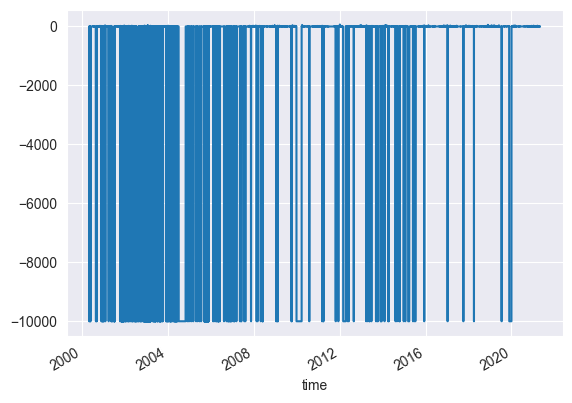

In [13]:
southeast[southeast.station_code=="A601"].prcp.plot()
plt.show()

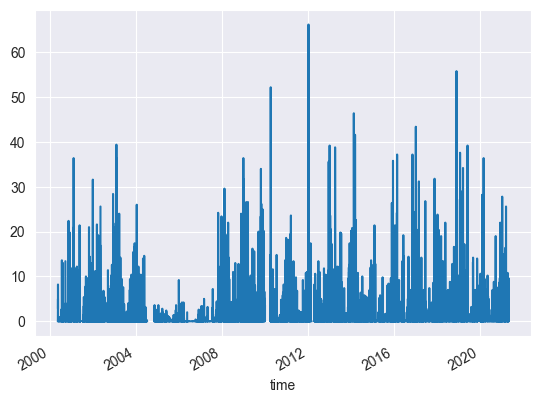

In [14]:
southeast[southeast.station_code=="A601"].replace(-9999, np.NaN).prcp.plot()
plt.show()

Revisemos si hay valores faltantes

In [16]:
southeast.isnull().sum()

prcp            0
paes            0
pmax            0
pmin            0
radg            0
tsec            0
troc            0
tmax            0
tmin            0
trmax           0
trmin           0
hmax            0
hmin            0
hrel            0
vdir            0
vcor            0
vvel            0
station_code    0
dtype: int64

Pero ya vimos que los valores faltantes estan marcados con -9999

In [19]:
southeast = southeast.replace(-9999, np.NaN)

In [20]:
southeast.isnull().sum()

prcp            1324496
paes            1114464
pmax            1122546
pmin            1122482
radg            7083207
tsec            1031262
troc            1216672
tmax            1038460
tmin            1038400
trmax           1225038
trmin           1237026
hmax            1190074
hmin            1201616
hrel            1189363
vdir            1430352
vcor            1405538
vvel            1387730
station_code          0
dtype: int64

In [25]:
station_A502 = southeast[southeast.station_code =="A502"]

In [26]:
station_A502.isnull().sum()

prcp            10983
paes             9725
pmax             9773
pmin             9773
radg            61097
tsec            11438
troc            14893
tmax            11448
tmin            11448
trmax           14700
trmin           15302
hmax            14058
hmin            14744
hrel            14319
vdir            16399
vcor            16428
vvel            16399
station_code        0
dtype: int64

### Visualización de los valores faltantes

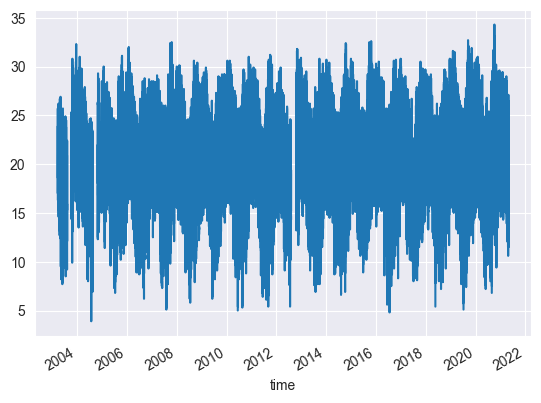

In [29]:
station_A502.tsec.plot()
plt.show()

Son muchos datos , vamos a hacer zoom en un rango en partiuclar. Podemos verificar que pasa en el año 2013.

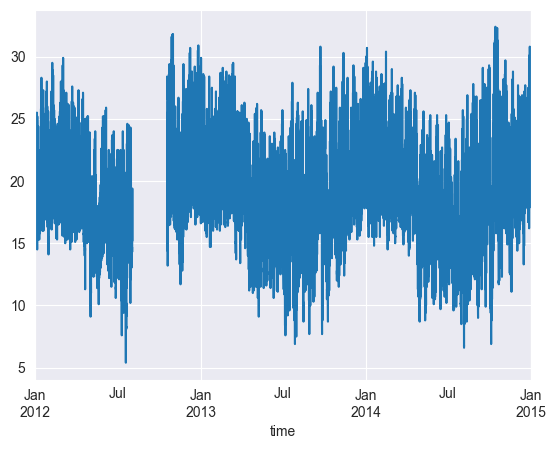

In [30]:
station_A502.sort_index().loc["2012-01-01": "2015-01-01"].tsec.plot()
plt.show()

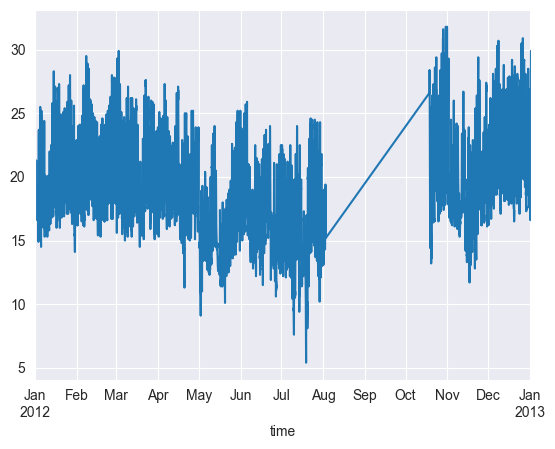

In [31]:
station_A502.tsec.interpolate("linear", limit_direction="both").sort_index().loc[
"2012-01-01":"2013-01-01"].plot()
plt.show()

Tambien podemos generar un heatmap para verificar los faltantes

<function matplotlib.pyplot.show(close=None, block=None)>

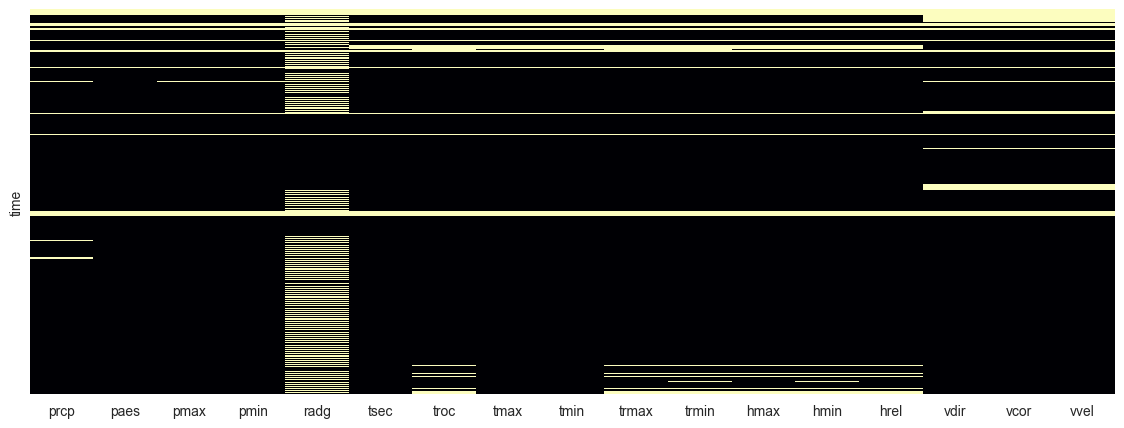

In [33]:
plt.figure(figsize=(14,5))
sns.heatmap(
    station_A502.loc[:, station_A502.columns != "station_code"].isnull(),
    cmap="magma",
    cbar = False,
    yticklabels=False,
)
plt.show

la figura muestra que radg tienen muchos datos faltantes. Vamos a comprobar e porentjae real la cantidad de datos que faltan.

El mapa de calor no puede capturar un porentaje pequeño como tmin y tmax debido a la diferencia de tamaño.

### Cálculo del porcentajo de valores infinitos
Vamos a calcular las columnas con más del 40# de valores faltantes

* ((df[col].isna().sum()*100) > df.shape[0]


devuelve el porcentaje de nulos en cada columna

* df[col].insa().sum()> round(0.4 * df.shape[0]

comprueba si el porcentaje de faltantes es superior al 40% del total

In [34]:
columns_40_percent_plus_null = {
    col: ((station_A502[col].isna().sum() * 100) / station_A502.shape[0])
    for col in station_A502.columns
}

In [35]:
columns_40_percent_plus_null

{'prcp': 6.8078696816423685,
 'paes': 6.028091837746702,
 'pmax': 6.057844887434295,
 'pmin': 6.057844887434295,
 'radg': 37.87129326589309,
 'tsec': 7.089903798472677,
 'troc': 9.231503520777546,
 'tmax': 7.096102350490925,
 'tmin': 7.096102350490925,
 'trmax': 9.111871466825349,
 'trmin': 9.485024298323912,
 'hmax': 8.713924427253794,
 'hmin': 9.139145095705643,
 'hrel': 8.875706634930081,
 'vdir': 10.165005454725776,
 'vcor': 10.182981255578698,
 'vvel': 10.165005454725776,
 'station_code': 0.0}

In [36]:
f"{station_A502['radg'].isna().sum() / len(station_A502):.2%}"

'37.87%'

podemos establecer com criterio borrar las columnas que tengan un número de faltantes por encima de un determinado umbral.

In [38]:
station_A502.dropna(subset=['tsec', 'tmax', 'tmin'], inplace=True)

In [39]:
station_A502

,prcp,paes,pmax,pmin,radg,tsec,troc,tmax,tmin,trmax,trmin,hmax,hmin,hrel,vdir,vcor,vvel,station_code
time,,,,,,,,,,,,,,,,,,
2003-03-21 00:00:00,0.0,889.6,889.6,888.9,NaN,18.6,16.7,18.6,17.9,17.0,16.7,94.0,89.0,89.0,NaN,NaN,NaN,A502
2003-03-21 01:00:00,0.0,889.1,889.6,889.1,NaN,19.4,16.7,19.9,18.6,16.8,16.6,88.0,82.0,85.0,NaN,NaN,NaN,A502
2003-03-21 02:00:00,0.0,889.3,889.4,889.1,NaN,19.0,16.5,19.4,18.8,16.8,16.5,88.0,84.0,85.0,NaN,NaN,NaN,A502
2003-03-21 03:00:00,0.0,888.8,889.3,888.8,NaN,19.0,16.4,19.2,18.8,16.8,16.4,86.0,84.0,85.0,NaN,NaN,NaN,A502
2003-03-21 04:00:00,0.0,887.9,888.7,887.9,NaN,19.0,16.4,19.1,18.9,16.5,16.3,86.0,84.0,85.0,NaN,NaN,NaN,A502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30 19:00:00,0.0,892.2,892.3,892.2,596.0,17.5,NaN,18.9,17.5,NaN,NaN,NaN,NaN,NaN,91.0,0.0,0.0,A502
2021-04-30 20:00:00,0.0,892.2,892.2,892.0,294.0,16.8,NaN,17.7,16.8,NaN,NaN,NaN,NaN,NaN,125.0,0.0,0.0,A502
2021-04-30 21:00:00,0.0,892.3,892.3,892.2,34.0,14.6,NaN,16.8,14.4,NaN,NaN,NaN,NaN,NaN,85.0,0.0,0.0,A502
